# ism3d.arts: model artificial sources in different shapes

## Setup

We first import essential API functions / modules from `ism3d` and other libraries

**Used ISM3D Functions:**

* `im3d.logger.logger_config`
* `im3d.logger.logger_status`

In [5]:
nb_dir=_dh[0]
os.chdir(nb_dir+'/../output/mockup')
sys.path.append(nb_dir)
from notebook_setup import *

%matplotlib inline
#%config InlineBackend.figure_format = "png" #  ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%reload_ext wurlitzer
%reload_ext memory_profiler
%reload_ext line_profiler

#ism3d.logger_config(logfile='ism3d.log',loglevel='INFO',logfilelevel='INFO',log2term=False)
ism3d.logger_config(logfile='ism3d.log',loglevel='DEBUG',logfilelevel='DEBUG',log2term=False)

print(''+ism3d.__version__)
print('working dir: {}\n'.format(os.getcwd()))

0.3.dev1
working dir: /Users/Rui/Resilio/Workspace/projects/ism3d/models/output/mockup



## 2D Analytic Model Rendering

We read the model configuration from a parameter file following [the INI file format](https://en.wikipedia.org/wiki/INI_file)).
Then we render it into a specifield WCS system for visulization purposes.

A 2D analytical object has the following properties:
+ the same spatial distribution at different frequency (thought the integrated flux can vary (described by frequency-depdendent fluxscale vector)
+ no inclination or object thickness, just flat "on-sky" prescription although there is a angular-physicallength transformation
+ 3D analytical model can be easily rendered into a regular grid (specified by WCS) and then rendered into UV data using the grid-to-sparse transform from FNUFFT.

**Used ISM3D Functions:**

* `ism3d.utils.meta.create_header`
* `ism3d.interface.read_inp`
* `ism3d.interface.inp_to_mod`
* `ism3d.modeling.model.model_realize`
* `ism3d.simxy.render.render_apmodel2d`

<Figure size 432x288 with 0 Axes>

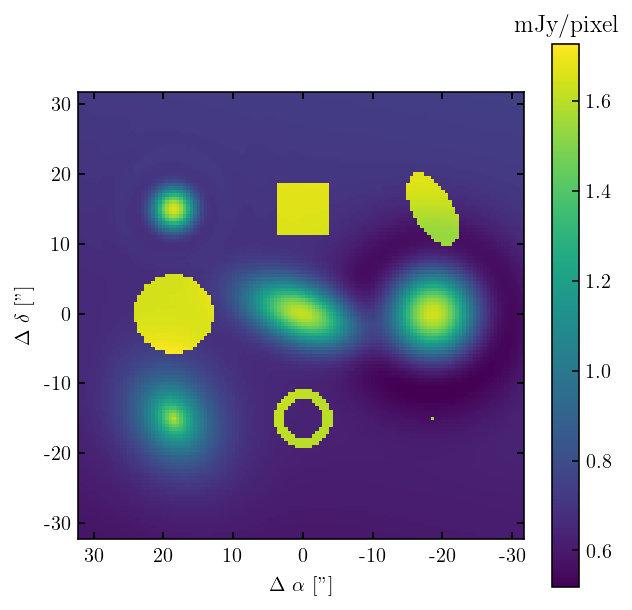

In [5]:
header=create_header(naxis=[128,128,120],
                     objname='arts.models',
                     crval=[189.2933333,62.3711111,45535299115.90349],
                     cdelt=[-0.5/3600,0.5/3600,2000013.13785553])

inpfile='../../input/mockup_apmodels.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)
model_name='mockup5'

from ism3d.simxy.render import render_apmodel2d as xy_render_apmodel2d
out=0
for obj in mod_dict:
    plane,fluxscale=xy_render_apmodel2d(mod_dict[obj],WCS(header),normalize=False)
    #print(obj,mod_dict[obj]['sbProf'],plane.sum(),np.max(plane),fluxscale[0].value)
    out=out+plane*fluxscale[0].value

fits.writeto('mockup_arts.fits',out,header,overwrite=True)
im_grid(out*1e3,header,offset=True,units=['mJy/pixel'],
        titles=None,nxy=(1,1),figsize=(5,5),
        figname='mockup_arts.pdf',showplot=True)

## 3D Sparse Model Rendering

Here, we render a model composed of three "sparse-array" 3D objectes/ The mapping destination is again specified by a WCS system and we visulize the results as an channel map animation.

A 3D "cloudlet" object has the following properties:
+ each object is described by a particle collection (sparse array). the equal-weight particle PDF and their kimeatical properties follow specified analytical prescriptions. Basically, it's a particle-based representation of the model object in terms of it's morphological and kinmeatic properties.
+ inclination and object thickness are incorperated, plus several transformation from the model system to on-sky system: orientation > physical-to-sky 

Note:
+ resolved line emission can only be described by 3D sparse model
+ A continue object stil be represented by a 3D sparse model.
+ 3D sparse model can be directly rendered into UV data using the sparse-to-sparse transform from FNUFFT

**Used ISM3D Functions:**

* `ism3d.utils.meta.create_header`
* `ism3d.interface.read_inp`
* `ism3d.interface.inp_to_mod`
* `ism3d.modeling.model.model_realize`
* `ism3d.simxy.render.render_apmodel2d`

In [74]:
header=create_header(naxis=[128,128,120],
                     objname='arts.models',
                     crval=[189.2933333,62.3711111,45535299115.90349],
                     cdelt=[-0.5/3600,0.5/3600,2000013.13785553])

inpfile='../../input/mockup_spmodel3d.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)
model_name='mockup5'

out=0
for obj in mod_dict:
    cube=xy_render_spmodel3d(mod_dict[obj],WCS(header))
    #print(obj,mod_dict[obj]['sbProf'],plane.sum(),np.max(plane),fluxscale[0].value)
    out=out+cube
#pprint(mod_dict) # the sparse models have been added as caching keywords clouds_wt/clouds_loc
    
fits.writeto('mockup_arts3d.fits',out,header,overwrite=True)


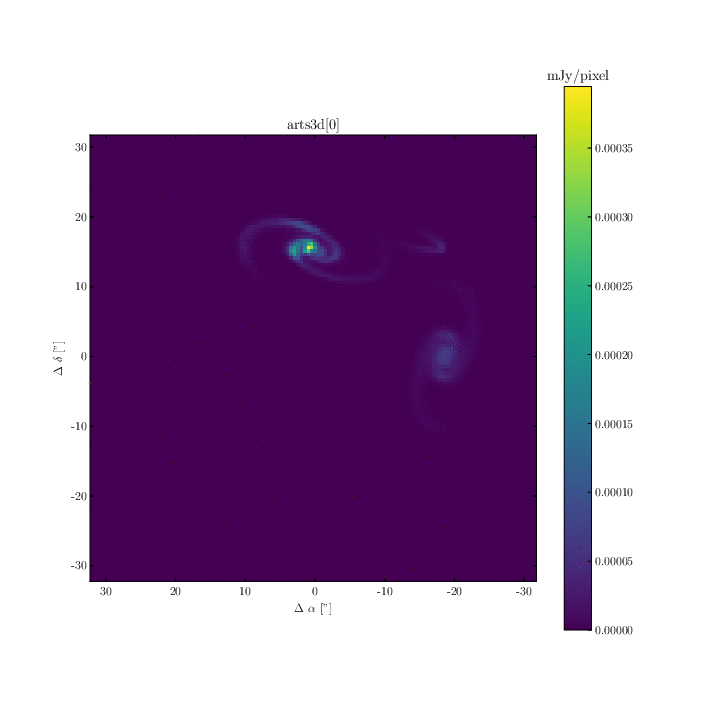

<Figure size 432x288 with 0 Axes>

In [75]:
nchan=header['NAXIS3']
stepchan= int(np.maximum(np.floor(int(nchan/20)),1))
vmax=np.nanmax(out)
vmin=np.nanmin(out)
fignames=[]
for ichan in range(0,nchan,stepchan):
    
    #clear_output(wait=True)
    figname='mockup_arts3d.chmap/ch{:03d}'.format(ichan)+'.pdf'
    images=[out[ichan,:,:]]
    titles=['arts3d['+'{}'.format(ichan)+']']
    im_grid(images*1000,header,offset=True,units=['mJy/pixel'],
            titles=titles,nxy=(1,1),figsize=(10,10),figname=figname,vmins=[vmin],vmaxs=[vmax]) ;
    fignames.append(figname) 

make_gif(fignames,'mockup_arts3d.chmap/chmap.gif')
show_gif('mockup_arts3d.chmap/chmap.gif')

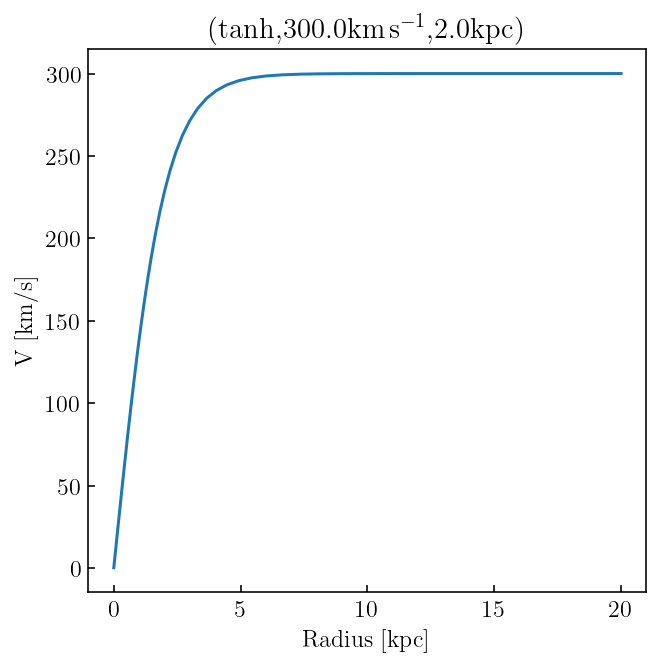

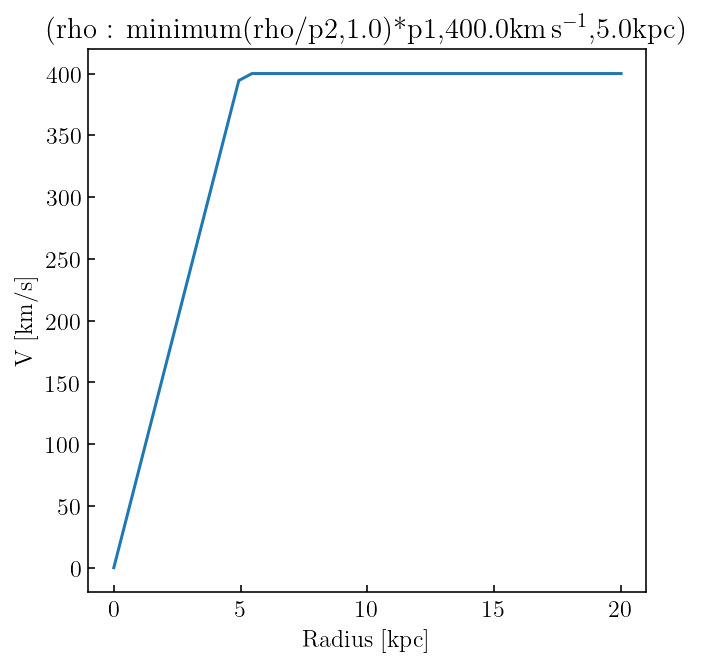

In [68]:
inpfile='../../input/mockup_spmodel3d.ini'
inp_dict=read_inp(inpfile)
mod_dict=inp_to_mod(inp_dict)

plt_rcProf(mod_dict['co21disk1']['rcProf'],showplot=True)
plt_rcProf(mod_dict['co21disk2']['rcProf'],showplot=True)

In [66]:
repr(mod_dict['co21disk1']['rcProf'][1])

'<Quantity 300. km / s>'

In [61]:
"{0.value}{0.unit:latex_inline}".format(mod_dict['co21disk1']['rcProf'][1])

'300.0$\\mathrm{km\\,s^{-1}}$'

In [62]:
"{0.value}{0.unit:latex_inline}".format(1)

AttributeError: 'int' object has no attribute 'value'